# CLIP zero shot classification

In [1]:
model_name = "effnetb0" # model that generates the prob labels, i.e. the ground truth

In [2]:
import os
import clip
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import root_mean_squared_error
import sklearn
from torch.nn.functional import kl_div 

# set seeds just in case randomness is involved -> should not be the case here though
np.random.seed(0)
torch.random.manual_seed(0)

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

In [3]:
def clip_zero_shot_classification(df, label_map):
    """performs zero shot classification using CLIP by comparing image and text embedding via the cosine distance.
    Returns a list of class probabibilities for all data points"""

    text_inputs = torch.cat([clip.tokenize(f"{c}") for c in list(label_map.values())]).to(device)

    with torch.no_grad():   # compute text embeddings 
        text_embeddings = model.encode_text(text_inputs) # generate text embeddings of captions "an image of an airplane, ..."

    image_embeddings = torch.tensor(np.array(df["CLIP"].to_list())).to(device)

    # Normalize embeddings
    image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)
    text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

    predicted_probabilities = (model.logit_scale.exp().item() * image_embeddings @ text_embeddings.T).softmax(dim=-1).cpu().numpy()

    return predicted_probabilities

def clip_zero_shot_classification_computing_embeddings(df, label_map, batch_size = 32):
    """performs zero shot classification using CLIP by comparing image and text embedding via the cosine distance.
    Returns a list of class probabibilities for all data points"""

    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in list(label_map.values())]).to(device)

    # Batch processing for image embeddings and prediction
    predicted_probabilities = []
    batch_size = 32

    with torch.no_grad():
        text_embeddings = model.encode_text(text_inputs) # generate text embeddings of captions "an image of an airplane, ..."

    for i in tqdm(range(0, len(df), batch_size)):
        i_end = min(i + batch_size, len(df))

        images = df["img"][i:i_end].to_list()
        # Preprocess the images and stack them into a batch
        image_inputs = torch.stack([preprocess(img) for img in images]).to(device)

        # Generate image embeddings
        with torch.no_grad():
            image_embeddings = model.encode_image(image_inputs)

        # Normalize embeddings
        image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)
        text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

        # Compute cosine similarity and turn it into a prob distribution
        probs = (model.logit_scale.exp().item() * image_embeddings @ text_embeddings.T).softmax(dim=-1).cpu().numpy() # the 100 here corresponds to the logit scale of the model which is clipped
        predicted_probabilities.extend(probs)

    return predicted_probabilities

def hist(df):
    # Add a "correct" column where 1 indicates a correct prediction and 0 indicates incorrect
    df["correct"] = (df["clip_zero_shot_pred"] == df["label"]).astype(int)

    # Calculate total relative frequencies for each class
    total_counts = df["clip_zero_shot_pred"].value_counts(normalize=True).sort_index()

    # Calculate the count of correct predictions per class
    correct_counts = df[df["correct"] == 1]["clip_zero_shot_pred"].value_counts().sort_index()

    # Calculate relative frequency of correct predictions
    relative_correct = (correct_counts / len(df)).reindex(total_counts.index, fill_value=0)

    # Calculate relative frequency of incorrect predictions
    relative_incorrect = total_counts - relative_correct

    # actual relative freqs
    actual_frequencies = df["label"].value_counts(normalize=True).sort_index()

    # Combine into a DataFrame for stacked plotting
    relative_frequencies = pd.DataFrame({
        "Correct": relative_correct,
        "Incorrect": relative_incorrect
    })

    # Plot stacked bar chart
    fig = plt.figure()
    ax = plt.gca()
    bar_plot = relative_frequencies.plot(ax = ax, kind='bar', stacked=True, color=["teal", "coral"], width=0.8)

    # Retrieve the width of the bars dynamically
    bar_width = bar_plot.containers[0].patches[0].get_width()

    # Add bounded horizontal lines for actual frequencies
    for i, (index, freq) in enumerate(actual_frequencies.items()):
        # Calculate the center position of each bar to align with x-axis tick positions
        x_center = i
        # Draw horizontal line bounded to the width of each bar
        ax.hlines(y=freq, xmin=x_center - bar_width / 2, xmax=x_center + bar_width / 2, 
                  colors="black", linestyles="--", linewidth=1, label="Actual" if i == 0 else "")



    plt.xlabel("Predicted Class (0-9)")
    plt.ylabel("Relative Frequency")
    plt.title("Relative Frequency of Predictions by Class with Correct Fraction")
    plt.xticks(rotation=0)
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(xmax=1))  # Format y-axis as percentages
    plt.legend(loc = 3)
    

    plt.show()

## CIFAR10

In [4]:
datasets = []
zero_shot_acc = []
rmses = []
maes = []
kls = []
tvs = []

In [5]:
dataset_name = "CIFAR10"
df = pd.read_pickle(f"data/prob_data/{dataset_name}/{dataset_name}.pkl")
print("Accuracy of Neural Network: %.2f"%(100*len(df.query(f"prediction_{model_name} == label"))/len(df)), "%")

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
label_map = {i: f"an image of a {classes[i]}" for i in range(len(classes))}

predicted_probabilities = clip_zero_shot_classification(df, label_map)

df["clip_zero_shot_prob"] = list(predicted_probabilities)
df["clip_zero_shot_pred"] = np.array(predicted_probabilities).argmax(axis=1)
print("clip zero shot accuracy: %.2f"%(100*len(df.query("clip_zero_shot_pred == label"))/len(df)), "%")

Accuracy of Neural Network: 95.80 %
clip zero shot accuracy: 89.04 %


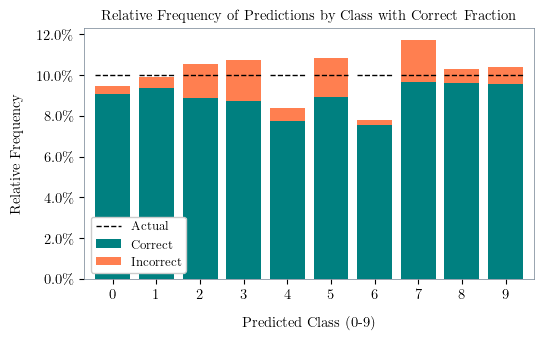

In [6]:
from scripts.plot import histogram, set_plot_layout
plot_params = set_plot_layout(path_to_latex = '/home/jklees/texlive/bin/x86_64-linux') # set plot layout (optional)
hist(df)

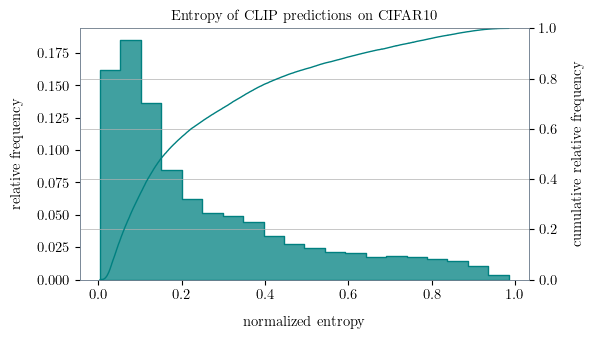

In [7]:
# get the probabilities by applying softmax on the cosine distances and scaling with temperature
from scipy.stats import entropy

labels = list(df["label"].unique())
df["entropy_clip"] = entropy(np.stack(df["clip_zero_shot_prob"].to_numpy()), axis=1) / np.log(len(labels))

title = f"Entropy of CLIP predictions on {dataset_name}"#f"Normalized entropy of efficient net prob. labels on {dataset_name}"
filename = None#f"plots/entropy on {dataset_name} efficient net b7.jpg"

histogram(df, x="entropy_clip", xlabel="normalized entropy", title=title, filename=filename)

In [8]:
p = np.array(df[f"prob_label_{model_name}"].to_list())
p_hat = np.array(df["clip_zero_shot_prob"].to_list())

r = root_mean_squared_error(p, p_hat)
mae = sklearn.metrics.mean_absolute_error(p_hat, p)
kl = kl_div(torch.tensor(p_hat).log(), torch.tensor(p), reduction = "batchmean").item()
tv = np.mean(np.max(np.abs(p - p_hat), axis=1))

datasets.append(dataset_name)
zero_shot_acc.append(len(df.query("clip_zero_shot_pred == label"))/len(df))
rmses.append(r)
maes.append(mae)
kls.append(kl)
tvs.append(tv)

print(f"RMSE of CLIP zero shot on {dataset_name}: %.3f"%r)

RMSE of CLIP zero shot on CIFAR10: 0.127


# CIFAR10-H

In [9]:
dataset_name = "CIFAR10-H"
df = pd.read_pickle(f"data/prob_data/{dataset_name}/{dataset_name}.pkl")
df["crowd_label"] = list(np.array(df["annotations"].to_list()).argmax(axis=1))
print("Accuracy of crowdsourced annotations: %.2f"%(100*len(df.query(f"crowd_label == label"))/len(df)), "%")

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
label_map = {i: f"an image of a {classes[i]}" for i in range(len(classes))}

predicted_probabilities = clip_zero_shot_classification(df, label_map)

df["clip_zero_shot_prob"] = list(predicted_probabilities)
df["clip_zero_shot_pred"] = np.array(predicted_probabilities).argmax(axis=1)
print("clip zero shot accuracy: %.2f"%(100*len(df.query("clip_zero_shot_pred == crowd_label"))/len(df)), "%")

Accuracy of crowdsourced annotations: 100.00 %
clip zero shot accuracy: 89.24 %


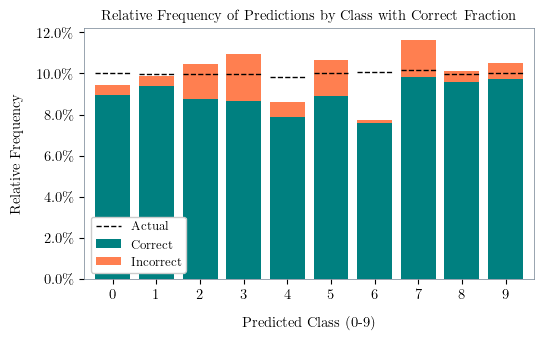

In [10]:
# for this function we need to redefine the label column to be the crowd label as this is actually the ground truth
df["label"] = df["crowd_label"]
hist(df)

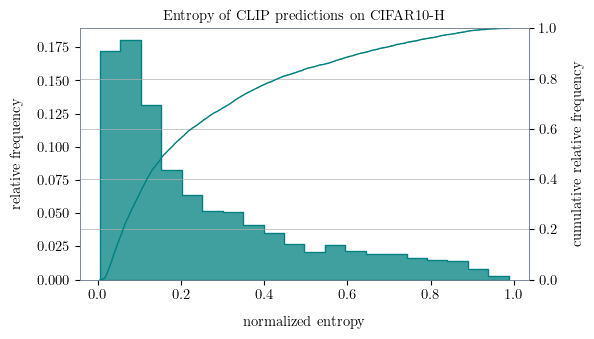

In [11]:
labels = list(df["label"].unique())
df["entropy_clip"] = entropy(np.stack(df["clip_zero_shot_prob"].to_numpy()), axis=1) / np.log(len(labels))

title = f"Entropy of CLIP predictions on {dataset_name}"
filename = None#f"plots/entropy of CLIP zero shot on {dataset_name}.jpg"

histogram(df, x="entropy_clip", xlabel="normalized entropy", title=title, filename=filename)

In [12]:
p = np.array(df[f"prob_label"].to_list())
p_hat = np.array(df["clip_zero_shot_prob"].to_list())

r = root_mean_squared_error(p, p_hat)
mae = sklearn.metrics.mean_absolute_error(p_hat, p)
kl = kl_div(torch.tensor(p_hat).log(), torch.tensor(p), reduction = "batchmean").item()
tv = np.mean(np.max(np.abs(p - p_hat), axis=1))

datasets.append(dataset_name)
zero_shot_acc.append(len(df.query("clip_zero_shot_pred == label"))/len(df))
rmses.append(r)
maes.append(mae)
kls.append(kl)
tvs.append(tv)

print(f"RMSE of CLIP zero shot on {dataset_name}: %.3f"%r)

RMSE of CLIP zero shot on CIFAR10-H: 0.110


## ANIMALS10

In [13]:
dataset_name = "ANIMALS10"
df = pd.read_pickle(f"data/prob_data/{dataset_name}/{dataset_name}.pkl")
print("Accuracy of Neural Network: %.2f"%(100*len(df.query(f"prediction_{model_name} == label"))/len(df)), "%")

Accuracy of Neural Network: 97.30 %


In [14]:
classes = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow','sheep', 'spyder', 'squirrel']
label_map = {i: f"an image of a {classes[i]}" for i in range(len(classes))}

predicted_probabilities = clip_zero_shot_classification(df, label_map)

df["clip_zero_shot_prob"] = list(predicted_probabilities)
df["clip_zero_shot_pred"] = np.array(predicted_probabilities).argmax(axis=1)
print("clip zero shot accuracy: %.2f"%(100*len(df.query("clip_zero_shot_pred == label"))/len(df)), "%")

clip zero shot accuracy: 97.78 %


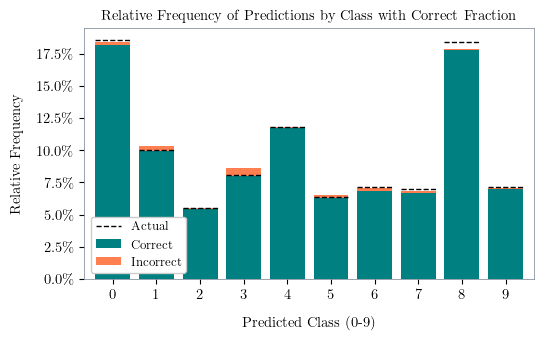

In [15]:
hist(df)

In [16]:
p = np.array(df[f"prob_label_{model_name}"].to_list())
p_hat = np.array(df["clip_zero_shot_prob"].to_list())

r = root_mean_squared_error(p, p_hat)
mae = sklearn.metrics.mean_absolute_error(p_hat, p)
kl = kl_div(torch.tensor(p_hat).log(), torch.tensor(p), reduction = "batchmean").item()
tv = np.mean(np.max(np.abs(p - p_hat), axis=1))

datasets.append(dataset_name)
zero_shot_acc.append(len(df.query("clip_zero_shot_pred == label"))/len(df))
rmses.append(r)
maes.append(mae)
kls.append(kl)
tvs.append(tv)

print(f"RMSE of CLIP zero shot on {dataset_name}: %.3f"%r)

RMSE of CLIP zero shot on ANIMALS10: 0.066


## EMNIST

In [17]:
dataset_name = "EMNIST"
df = pd.read_pickle(f"data/prob_data/{dataset_name}/{dataset_name}.pkl")
print("Accuracy of Neural Network: %.2f"%(100*len(df.query(f"prediction_{model_name} == label"))/len(df)), "%")

Accuracy of Neural Network: 99.67 %


In [18]:
classes = [str(i) for i in range(10)]
label_map = {i: f"a black and white image of the handwritten digit {classes[i]}" for i in range(len(classes))}

predicted_probabilities = clip_zero_shot_classification(df, label_map)

df["clip_zero_shot_prob"] = list(predicted_probabilities)
df["clip_zero_shot_pred"] = np.array(predicted_probabilities).argmax(axis=1)
print("clip zero shot accuracy: %.2f"%(100*len(df.query("clip_zero_shot_pred == label"))/len(df)), "%")

clip zero shot accuracy: 43.17 %


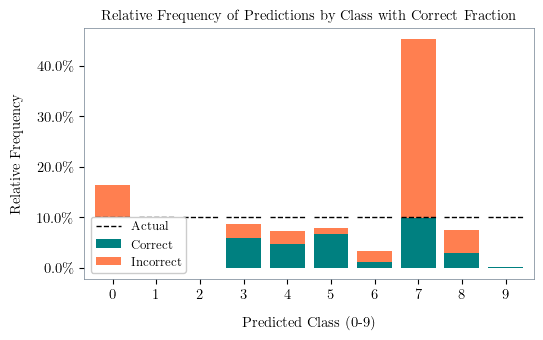

In [19]:
hist(df)

In [20]:
p = np.array(df[f"prob_label_{model_name}"].to_list())
p_hat = np.array(df["clip_zero_shot_prob"].to_list())

r = root_mean_squared_error(p, p_hat)
mae = sklearn.metrics.mean_absolute_error(p_hat, p)
kl = kl_div(torch.tensor(p_hat).log(), torch.tensor(p), reduction = "batchmean").item()
tv = np.mean(np.max(np.abs(p - p_hat), axis=1))

datasets.append(dataset_name)
zero_shot_acc.append(len(df.query("clip_zero_shot_pred == label"))/len(df))
rmses.append(r)
maes.append(mae)
kls.append(kl)
tvs.append(tv)

print(f"RMSE of CLIP zero shot on {dataset_name}: %.3f"%r)

RMSE of CLIP zero shot on EMNIST: 0.289


### MNIST

In [21]:
# import torchvision
# from PIL import Image
# # Load MNIST dataset into memory without saving to disk
# MNIST = torchvision.datasets.MNIST(
#     root='./data/datasets', train=True, download=True
# )

# data = {
#     "feature": [x.numpy().flatten() for x in MNIST.data],
#     "label": [l.numpy() for l in MNIST.targets]
# }
# df = pd.DataFrame(data)

# # load CLIP model
# device = "cuda" if torch.cuda.is_available() else "cpu"
# clip_model, preprocess = clip.load('ViT-B/32', device)

# # Function to process and reduce image features
# def reduce_image_features(image_array):
#     # Convert array to 28 x 28 grayscale image and transpose to display the digit properly
#     image = image_array.reshape(28, 28).astype(np.uint8)  
#     pil_image = Image.fromarray(image)  
#     # Scale image to 32 x 32, the required size for CLIP
#     scaled_image = pil_image.resize((32, 32), Image.BILINEAR)
#     # Convert image to tensor
#     image_tensor = preprocess(scaled_image).unsqueeze(0).to(device)
#     # Reduce image with CLIP
#     with torch.no_grad():
#         reduced_features = clip_model.encode_image(image_tensor)
#     return reduced_features.cpu().numpy().flatten()  # Flatten to a 1D array

# image_arrays = np.array(df['feature'].tolist())
# reduced_features = np.array([reduce_image_features(image_array) for image_array in image_arrays])
# df["CLIP"] = list(reduced_features)



# classes = [str(i) for i in range(10)]
# label_map = {i: f"a black and white image of the handwritten digit {classes[i]}" for i in range(len(classes))}

# predicted_probabilities = clip_zero_shot_classification(df, label_map)

# df["clip_zero_shot_prob"] = list(predicted_probabilities)
# df["clip_zero_shot_pred"] = np.array(predicted_probabilities).argmax(axis=1)
# print("clip zero shot accuracy: %.2f"%(100*len(df.query("clip_zero_shot_pred == label"))/len(df)), "%")

# hist(df)

46.08 % on MNIST

## Tiny Image Net

In [22]:
dataset_name = "TinyImageNet"
df = pd.read_pickle(f"data/prob_data/{dataset_name}/{dataset_name}.pkl")
print("Accuracy of Neural Network: %.2f"%(100*len(df.query(f"prediction_{model_name} == label"))/len(df)), "%")

Accuracy of Neural Network: 78.25 %


In [23]:
# import ast

# # Load the text file and parse it as a dictionary
# with open("data/datasets/tiny-imagenet-200/imagenet1000_clsidx_to_labels.txt", "r") as file:
#     data_dict = ast.literal_eval(file.read())

# # Convert the dictionary to a DataFrame
# imagenet_classes = pd.DataFrame.from_dict(data_dict, orient='index', columns=['Label'])

# # Optionally reset the index to have a sequential integer index
# imagenet_classes.reset_index(inplace=True)
# imagenet_classes.columns = ['id', 'label']  # Renaming columns

# # add more simple labels

# import json

# # https://github.com/anishathalye/imagenet-simple-labels/blob/master/imagenet-simple-labels.json

# with open("data/datasets/tiny-imagenet-200/imagenet-simple-labels.json") as f:
#     labels = json.load(f)

# def class_id_to_label(i):
#     return labels[i]

# imagenet_classes["simple_label"] = [class_id_to_label(i) for i in imagenet_classes.index]

# # map labels of tiny image net to simpler ones

# labels = [df.query("label == %d" % i)["class_name"].values[0] for i in range(200)]
# simple_labels = [imagenet_classes.query(f'label == "{label}"')["simple_label"].values[0] for label in labels]

# simple_label_map = {i: f'an image of a {simple_labels[i]}' for i in range(200)} # simpler labels

# predicted_probabilities = clip_zero_shot_classification(df, simple_label_map)

# df["clip_zero_shot_prob"] = list(predicted_probabilities)
# df["clip_zero_shot_pred"] = np.array(predicted_probabilities).argmax(axis=1)
# print("clip zero shot accuracy (simple labels): %.2f"%(100*len(df.query("clip_zero_shot_pred == label"))/len(df)), "%")




In [24]:
label_map = {i: f'an image of a {df.query("label == %d" % i)["class_name"].values[0]}' for i in range(200)} # original imagenet labels


predicted_probabilities = clip_zero_shot_classification(df, label_map)

df["clip_zero_shot_prob"] = list(predicted_probabilities)
df["clip_zero_shot_pred"] = np.array(predicted_probabilities).argmax(axis=1)
print("clip zero shot accuracy: %.2f"%(100*len(df.query("clip_zero_shot_pred == label"))/len(df)), "%")

clip zero shot accuracy: 57.13 %


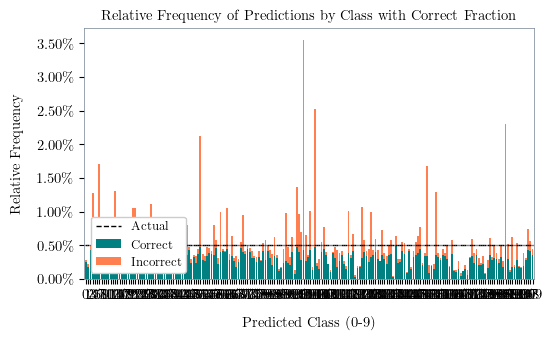

In [25]:
hist(df)

In [26]:
p = np.array(df[f"prob_label_{model_name}"].to_list())
p_hat = np.array(df["clip_zero_shot_prob"].to_list())

r = root_mean_squared_error(p, p_hat)
mae = sklearn.metrics.mean_absolute_error(p_hat, p)
kl = kl_div(torch.tensor(p_hat).log(), torch.tensor(p), reduction = "batchmean").item()
tv = np.mean(np.max(np.abs(p - p_hat), axis=1))

datasets.append(dataset_name)
zero_shot_acc.append(len(df.query("clip_zero_shot_pred == label"))/len(df))
rmses.append(r)
maes.append(mae)
kls.append(kl)
tvs.append(tv)

print(f"RMSE of CLIP zero shot on {dataset_name}: %.3f"%r)

RMSE of CLIP zero shot on TinyImageNet: 0.044


## MTSD

In [27]:
dataset_name = "MTSD"
df = pd.read_pickle(f"data/prob_data/{dataset_name}/{dataset_name}.pkl")
# df = pd.read_pickle(f"/home/jklees/backup_prob_data/{dataset_name}/{dataset_name}.pkl")
print("Accuracy of assigned prob labels: 100%")

Accuracy of assigned prob labels: 100%


In [28]:
df.head(2)

,image_path,img,feature,label,prob_label,CLIP,RESNET,VIT,CLIP_UMAP_20,RESNET_UMAP_20,VIT_UMAP_20
0,datasets/MTSD/data/crops/-045ksJVc_QDsaI8gpCrz...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[222, 226, 225, 223, 227, 226, 229, 231, 230, ...",0,"[0.4241177637535616, 0.0890152130527567, 0.121...","[-0.3687, 0.327, 0.4783, 0.3794, -0.1192, -0.6...","[0.0027502745, 0.0, 0.1018825, 0.043218356, 0....","[0.052958336, -0.484285, 0.5098982, 0.50848204...","[9.936919, 8.544932, 3.8526754, 5.4160748, 7.7...","[7.1432347, 9.953808, 6.8691993, 9.964029, 7.4...","[6.6517224, 6.5384307, 7.4628925, 0.048721805,..."
1,datasets/MTSD/data/crops/-0G6gt8ksR0hO5jMKrTDM...,<PIL.Image.Image image mode=RGB size=224x224 a...,"[68, 79, 78, 68, 78, 77, 65, 75, 74, 62, 71, 7...",1,"[0.0762148183676129, 0.5218003365598036, 0.083...","[0.4192, 0.1567, 0.3496, 0.02847, 0.1543, -0.1...","[0.012295557, 0.0029715835, 0.0, 0.38578376, 0...","[-0.9353727, -0.21142848, -1.064077, 1.1665258...","[9.988558, 9.271524, 3.118933, 6.1867046, 6.57...","[5.8425756, 9.976718, 6.476398, 10.006671, 9.1...","[6.05808, 6.867759, 4.152538, 0.041032955, 5.2..."


In [29]:
label_map = {0:"an image of a street sign in the shape of a rectangle",
             1:"an image of a street sign in the shape of a diamond", 
             2:"an image of a street sign of unusual shape", # street sign in the shape other than a rectangle, diamond, triangle, circle or octagon
             3:"an image of a street sign in the shape of a triangle",
             4:"an image of a street sign in the shape of an octagon",
             5:"an image of a street sign in the shape of a circle",
             6:"an image of a street sign that is not fully visible"}

predicted_probabilities = clip_zero_shot_classification(df, label_map)

df["clip_zero_shot_prob"] = list(predicted_probabilities)
df["clip_zero_shot_pred"] = np.array(predicted_probabilities).argmax(axis=1)
print("clip zero shot accuracy: %.2f"%(100*len(df.query("clip_zero_shot_pred == label"))/len(df)), "%")

clip zero shot accuracy: 19.35 %


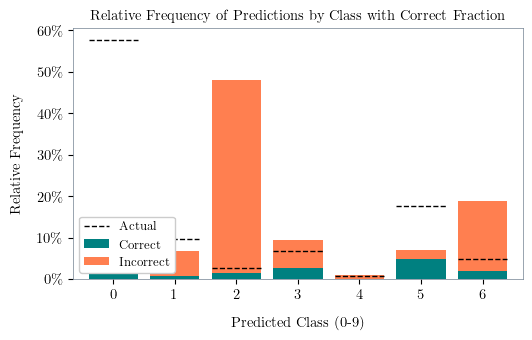

In [30]:
hist(df)

In [31]:
p = np.array(df[f"prob_label"].to_list())
p_hat = np.array(df["clip_zero_shot_prob"].to_list())

r = root_mean_squared_error(p, p_hat)
mae = sklearn.metrics.mean_absolute_error(p_hat, p)
kl = kl_div(torch.tensor(p_hat).log(), torch.tensor(p), reduction = "batchmean").item()
tv = np.mean(np.max(np.abs(p - p_hat), axis=1))

datasets.append(dataset_name)
zero_shot_acc.append(len(df.query("clip_zero_shot_pred == label"))/len(df))
rmses.append(r)
maes.append(mae)
kls.append(kl)
tvs.append(tv)

print(f"RMSE of CLIP zero shot on {dataset_name}: %.3f"%r)

RMSE of CLIP zero shot on MTSD: 0.164


In [32]:
clip_results = pd.DataFrame({"dataset":datasets, "zero_shot_accuracy": zero_shot_acc, "RMSE": rmses, "MAE": maes, "KL": kls, "TV": tvs})

clip_results.to_csv("results/clip_zero_shot_results.csv")

clip_results["zero_shot_accuracy"] = clip_results["zero_shot_accuracy"]*100


In [33]:
latex_code = clip_results.to_latex(header= ["Dataset", "Accuracy", "RMSE", "MAE", "KL", "TV"],
column_format="c|r|r|r|r|r", caption = "CLIP zero shot classification",
formatters = {"zero_shot_accuracy": lambda x: f"{x:.2f}\,\%", 
              "RMSE": lambda x: f"{x:.4f}", "MAE": lambda x: f"{x:.4f}", 
              "KL": lambda x: f"{x:.4f}", "TV": lambda x: f"{x:.4f}"}, index = False)

from IPython.display import Markdown
Markdown(f"```latex\n{latex_code}\n```")

```latex
\begin{table}
\caption{CLIP zero shot classification}
\begin{tabular}{c|r|r|r|r|r}
\toprule
Dataset & Accuracy & RMSE & MAE & KL & TV \\
\midrule
CIFAR10 & 89.04\,\% & 0.1270 & 0.0426 & 0.3828 & 0.2104 \\
CIFAR10-H & 89.24\,\% & 0.1105 & 0.0375 & 0.3039 & 0.1815 \\
ANIMALS10 & 97.78\,\% & 0.0662 & 0.0125 & inf & 0.0610 \\
EMNIST & 43.17\,\% & 0.2886 & 0.1718 & 2.0424 & 0.8584 \\
TinyImageNet & 57.13\,\% & 0.0437 & 0.0051 & inf & 0.4333 \\
MTSD & 19.35\,\% & 0.1640 & 0.1189 & 0.5930 & 0.3377 \\
\bottomrule
\end{tabular}
\end{table}

```

## Two Moons

In [34]:
df = pd.read_pickle("data/prob_data/TwoMoons/TwoMoons.pkl")
print("Accuracy of Neural Network: %.2f"%(100*len(df.query("neural_network_prediction == label"))/len(df)), "%")
df.head(2)

Accuracy of Neural Network: 99.92 %


,feature,x,y,label,neural_network_prediction,most_probable_class,prob_label
0,"[1.972765156192938, 0.020589648610691846]",1.972765,0.020590,1,1,1,"[5.316734313964844e-05, 0.9999468326568604]"
1,"[0.9145108935538406, 0.5128518761932918]",0.914511,0.512852,0,0,0,"[0.9985553233418614, 0.0014446766581386328]"
